In [72]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

def get_price(ticker, start, end, interval='1d'):
    """interval : str
            Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
            Intraday data cannot extend last 60 days
    """
    return yf.download(ticker, start=start, end=end, interval=interval, auto_adjust=True, progress=False)


Step 1: download single stock data and format it

In [2]:
# Apple prices from yahoo
# end of day data, the index is Data
# it is a datetime index with frequency None
apple_EOD_prices = get_price(ticker='AAPL', start='2024-01-01', end='2024-05-18', interval='1d')
apple_EOD_prices.head()

,Open,High,Low,Close,Volume
Date,,,,,
2024-01-02,186.658310,187.944930,183.406880,185.152283,82488700
2024-01-03,183.736010,185.391653,182.948077,183.765930,58414500
2024-01-04,181.671458,182.608991,180.404806,181.432098,71983600
2024-01-05,181.511879,182.279846,179.696654,180.703995,62303300
2024-01-08,181.611610,185.112398,181.023163,185.072495,59144500


In [3]:
# now resample with frequence Business days. The function asfreq() will 
# leave NaNs in days without data. You could use some other functions like ffill().
# NEVER use bfill() in timeseries, since it will use future data to fill past data.
# this leads to a look forward bias
apple_EOD_prices = apple_EOD_prices.resample('B').asfreq()
apple_EOD_prices.index.freq

<BusinessDay>

Step 2: download some other stocks and merge the dataframes

In [4]:
# download prices for Microsoft and Nvidia
microsoft_EOD_prices = get_price(ticker='MSFT', start='2024-01-01', end='2024-05-18', interval='1d')
nvidia_EOD_prices = get_price(ticker='NVDA', start='2024-01-01', end='2024-05-18', interval='1d')

In [5]:
# format index to business days
microsoft_EOD_prices = microsoft_EOD_prices.resample('B').asfreq()
nvidia_EOD_prices = nvidia_EOD_prices.resample('B').asfreq()

In [6]:
# let us now merge the data to get a dataframe containing all prices for all stocks
# in order to do this we will add a column to each dataframe called 'Asset' with stock name
# then we will concatenate the dataframes and then manipulate the indexes

apple_EOD_prices['Asset'] = 'AAPL'
microsoft_EOD_prices['Asset'] = 'MSFT'
nvidia_EOD_prices['Asset'] = 'NVDA'

# since all dataframes have the same indexes and columns we can do this
prices_df = pd.concat([apple_EOD_prices, microsoft_EOD_prices, nvidia_EOD_prices])
prices_df.sort_index().head(6)

# you can notice that now we have a dataframe indexed by Date, with frequency 'B',
# and with coulmns open high low close volume. The addidional column Asset is useful
# to keep track of what stock we are referring to.

,Open,High,Low,Close,Volume,Asset
Date,,,,,,
2024-01-02,186.658310,187.944930,183.406880,185.152283,82488700.0,AAPL
2024-01-02,492.416915,492.926901,475.927698,481.657410,41125400.0,NVDA
2024-01-02,372.498019,374.530595,365.433851,369.518921,25258600.0,MSFT
2024-01-03,183.736010,185.391653,182.948077,183.765930,58414500.0,AAPL
2024-01-03,474.827737,481.817400,473.177821,475.667694,32089600.0,NVDA
2024-01-03,367.665704,371.900222,367.167526,369.249908,23083500.0,MSFT


In [7]:
# let us monipulate once more the indexes in order to have a nice indexed dataframe

# let us first reset the index
prices_df = prices_df.reset_index()

# let's now add Asset as index
prices_df = prices_df.set_index(['Date', 'Asset'])

prices_df = prices_df.sort_index()
prices_df.head(6)

Open        High         Low       Close      Volume
Date       Asset                                                            
2024-01-02 AAPL   186.658310  187.944930  183.406880  185.152283  82488700.0
           MSFT   372.498019  374.530595  365.433851  369.518921  25258600.0
           NVDA   492.416915  492.926901  475.927698  481.657410  41125400.0
2024-01-03 AAPL   183.736010  185.391653  182.948077  183.765930  58414500.0
           MSFT   367.665704  371.900222  367.167526  369.249908  23083500.0
           NVDA   474.827737  481.817400  473.177821  475.667694  32089600.0

Example 1: Open to Close daily returns

In [8]:
# now it is really easy to work with this kind of dataframe, for example, let's say
# that you wanted to compute something simple like daily open to close returns for each
# day and each asset, you could do like this:

prices_df['open_to_close_returns'] = (prices_df['Close'] / prices_df['Open']) - 1

prices_df[['open_to_close_returns']].head(6)

open_to_close_returns
Date       Asset                       
2024-01-02 AAPL               -0.008068
           MSFT               -0.007998
           NVDA               -0.021850
2024-01-03 AAPL                0.000163
           MSFT                0.004309
           NVDA                0.001769

In [9]:
# we can now work this in a simpler way like
prices_df['open_to_close_returns'].unstack().head()

Asset,AAPL,MSFT,NVDA
Date,,,
2024-01-02,-0.008068,-0.007998,-0.021850
2024-01-03,0.000163,0.004309,0.001769
2024-01-04,-0.001318,-0.007365,0.004836
2024-01-05,-0.004451,-0.003307,0.013103
2024-01-08,0.019057,0.014595,0.055360


Text(0.5, 0.98, 'Open to Close Returns Distribution\n')

<Figure size 640x480 with 0 Axes>

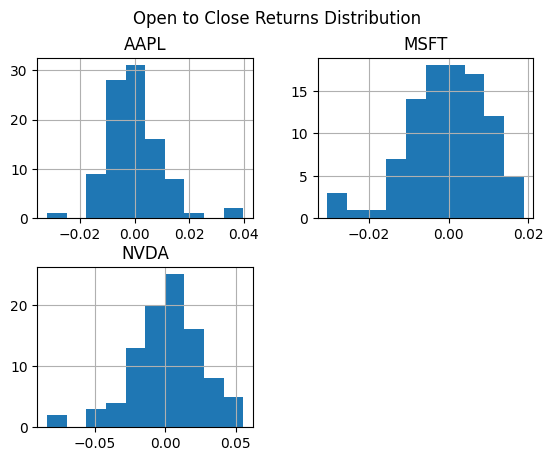

In [80]:
fg = plt.figure()
prices_df['open_to_close_returns'].unstack().hist()
plt.suptitle('Open to Close Returns Distribution')

Example 2: Close to Close returns

In [11]:
# a more complex exercise can be to compute close to close returns
# we will use the groupby function

# the index is already sorted
prices_df['close_to_close_returns'] = prices_df.groupby('Asset')['Close'].pct_change(1)
prices_df[['close_to_close_returns']].head(12)

close_to_close_returns
Date       Asset                        
2024-01-02 AAPL                      NaN
           MSFT                      NaN
           NVDA                      NaN
2024-01-03 AAPL                -0.007488
           MSFT                -0.000728
           NVDA                -0.012436
2024-01-04 AAPL                -0.012700
           MSFT                -0.007178
           NVDA                 0.009018
2024-01-05 AAPL                -0.004013
           MSFT                -0.000516
           NVDA                 0.022897

Text(0.5, 0.98, 'Close to Close Returns Distribution')

<Figure size 640x480 with 0 Axes>

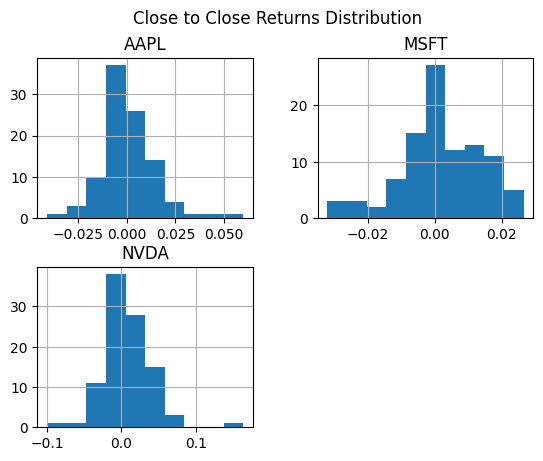

In [81]:
# as you can see the first values for each asset are NaNs, since we can't compute returns 
# since we don't have a previous close value.
# again, we can use the unstack() function of pandas if needed

fg = plt.figure()
prices_df['close_to_close_returns'].unstack().hist()
plt.suptitle('Close to Close Returns Distribution')

Example 3: sum of daily volume of the stocks

In [24]:
# we now want to know what the sum of daily volumes is
# we will use groupby on 'Date' index
# we will use trasform in order to keep the indexes nice
# as you can see, for each Date the sum of volumes is the same

prices_df['sum_of_daily_volumes'] = prices_df.groupby('Date')['Volume'].transform(lambda x: x.sum())
prices_df[['sum_of_daily_volumes']].head(6)

sum_of_daily_volumes
Date       Asset                      
2024-01-02 AAPL            148872700.0
           MSFT            148872700.0
           NVDA            148872700.0
2024-01-03 AAPL            113587600.0
           MSFT            113587600.0
           NVDA            113587600.0

Example 4: selecting a specific asset price curve

In [42]:
# select a specific slice of the dataframe using the first index
prices_df.loc['2024-01-02', 'Open']

Asset
AAPL    186.658310
MSFT    372.498019
NVDA    492.416915
Name: Open, dtype: float64

<Axes: title={'center': 'AAPL Close Price'}, xlabel='Date'>

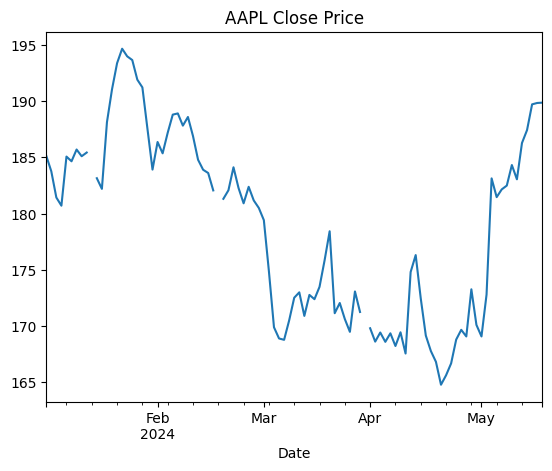

In [50]:
# select a specific asset curve
prices_df.swaplevel(0,1).loc['AAPL', 'Close']

prices_df.swaplevel(0,1).loc['AAPL', 'Close'].plot(title='AAPL Close Price')

Esample 5: weekly returns

In [37]:
# resample taking the price of each monday
# notice that with asfreq we don't have bank holidays
# for example, in USA 2024-01-15 is Martin Luther King Day
# while 2024-02-19 is Presidents Day
prices_df['Close'].unstack().resample('W-Mon').asfreq().head(8)

Asset,AAPL,MSFT,NVDA
Date,,,
2024-01-08,185.072495,373.325012,522.505493
2024-01-15,NaN,NaN,NaN
2024-01-22,193.380600,395.065521,596.512024
2024-01-29,191.226273,408.227386,624.620728
2024-02-05,187.186920,404.172241,693.287476
2024-02-12,186.896500,413.747223,722.446106
2024-02-19,NaN,NaN,NaN
2024-02-26,180.914627,406.806244,790.882874


In [38]:
# we can use the resample function "last" to fill these nans with the last available price
prices_df['Close'].unstack().resample('W-Mon').last().head(8)

Asset,AAPL,MSFT,NVDA
Date,,,
2024-01-08,185.072495,373.325012,522.505493
2024-01-15,185.431549,387.054810,547.074341
2024-01-22,193.380600,395.065521,596.512024
2024-01-29,191.226273,408.227386,624.620728
2024-02-05,187.186920,404.172241,693.287476
2024-02-12,186.896500,413.747223,722.446106
2024-02-19,182.063049,403.332489,726.095947
2024-02-26,180.914627,406.806244,790.882874


In [55]:
# select a specific slice of the dataframe to show that we kept the last available datapoint
prices_df.loc['2024-01-11':'2024-01-15', 'Close'].unstack()

# as you can see there is no available data for 2024-01-15.
# with last we get values for 2024-01-12 and tag it 2024-01-15, as expected

Asset,AAPL,MSFT,NVDA
Date,,,
2024-01-11,185.102417,383.22879,548.194275
2024-01-12,185.431549,387.05481,547.074341
2024-01-15,NaN,NaN,NaN


In [63]:
#we can now compute weekly returns
weekly_returns = prices_df['Close'].unstack().resample('W-Mon').last().pct_change()
weekly_returns.head()

Asset,AAPL,MSFT,NVDA
Date,,,
2024-01-08,NaN,NaN,NaN
2024-01-15,0.001940,0.036777,0.047021
2024-01-22,0.042868,0.020697,0.090367
2024-01-29,-0.011140,0.033316,0.047122
2024-02-05,-0.021123,-0.009934,0.109934


In [64]:
# as a last passage, let us say that we want to add this information to our prices_df
# first of all we resample the index to Business days
weekly_returns = weekly_returns.resample('B').ffill()
weekly_returns.head(10)
# remember to do ffill and not bfill, since we don't want to see the future

Asset,AAPL,MSFT,NVDA
Date,,,
2024-01-08,NaN,NaN,NaN
2024-01-09,NaN,NaN,NaN
2024-01-10,NaN,NaN,NaN
2024-01-11,NaN,NaN,NaN
2024-01-12,NaN,NaN,NaN
2024-01-15,0.00194,0.036777,0.047021
2024-01-16,0.00194,0.036777,0.047021
2024-01-17,0.00194,0.036777,0.047021
2024-01-18,0.00194,0.036777,0.047021


In [65]:
# then stack the dataframe to have the right index
weekly_returns = weekly_returns.stack()
weekly_returns.head(5)

# notice that this will get rid of Date with all nans

Date        Asset
2024-01-15  AAPL     0.001940
            MSFT     0.036777
            NVDA     0.047021
2024-01-16  AAPL     0.001940
            MSFT     0.036777
dtype: float64

In [71]:
# then simply add this information as a column of prices_df
prices_df['weekly_returns'] = weekly_returns
prices_df['weekly_returns'].tail(6)

Date        Asset
2024-05-16  AAPL     0.026540
            MSFT     0.000435
            NVDA    -0.018895
2024-05-17  AAPL     0.026540
            MSFT     0.000435
            NVDA    -0.018895
Name: weekly_returns, dtype: float64